In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [5]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [6]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [7]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)
    #Yb = Yb.type(torch.LongTensor)

    return Xb, Yb

#todo: mettre les shapes a cote

In [219]:
d_model = 32
n_heads = 2
d_head = d_model // n_heads

d_query = 16
d_key = d_query
d_value = d_head

embed_dim = d_model

In [220]:
class NewGELU(nn.Module):
    """
    GELU paper: https://arxiv.org/abs/1606.08415
    """
    
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.X_to_query = nn.Linear(d_model, d_query, bias=False)
        self.X_to_key = nn.Linear(d_model, d_key, bias=False)
        self.X_to_value = nn.Linear(d_model, d_value, bias=False)

    def forward(self, X):
        # X : (B, T, embed_dim), targets: (B, T)

        B, T, _ = X.size()

        Q = self.X_to_query(X) # (B, T, d_query)
        K = self.X_to_key(X) # (B, T, d_key=d_query)
        V = self.X_to_value(X) # (B, T, d_value)

        QK_T = Q @ torch.transpose(K, 1, 2) # (B, T, T)

        mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
        QK_T[:, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T / math.sqrt(d_key), dim=2) # (B, T, T)
        attention = attention_scores @ V # (B, T, d_value=d_head)

        return attention
    
class SelfAttentionMultiHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.X_to_query = nn.Linear(d_model, n_heads*d_query, bias=False)
        self.X_to_key = nn.Linear(d_model, n_heads*d_key, bias=False)
        self.X_to_value = nn.Linear(d_model, n_heads*d_value, bias=False) # d_value = d_head

    def forward(self, X):
        # X : (B, T, d_model), targets: (B, T)

        B, T, _ = X.size()

        Q = self.X_to_query(X).view(B, n_heads, T, d_query)
        K = self.X_to_key(X).view(B, n_heads, T, d_key)
        V = self.X_to_value(X).view(B, n_heads, T, d_head) # d_value = d_head

        QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_h, T, T)

        mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
        QK_T[:, :, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T / math.sqrt(d_key), dim=3) # (B, n_h, T, T)
        attention = attention_scores @ V # (B, n_h, T, d_value=d_head)

        attention = attention.transpose(1, 2) # (B, T, n_h, d_head)
        attention = attention.contiguous().view(B, T, n_heads*d_head) # n_heads*d_head = d_model

        return attention
    
class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()

        #self.sa = SelfAttention()
        self.sa = SelfAttentionMultiHead()
        self.l1 = nn.LayerNorm(d_model)
        self.fc1 = nn.Linear(d_model, 4*d_model)
        self.act = NewGELU()
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.l2 = nn.LayerNorm(d_model)

    def forward(self, X): # (B, T, d_model)
        H = self.l1(X + self.sa(X)) #sublayer 1 = SA
        H = self.l2(H + self.fc2(self.act(self.fc1(H)))) #sublayer 2 = FC
        return H
    
class Transformer_LM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0)
        self.PE = nn.Parameter(torch.randn(max_len, embed_dim)/10)

        self.layer1 = DecoderLayer()
        self.layer2 = DecoderLayer()

        self.lm_head = nn.Linear(d_model, len(vocabulaire))

    def forward(self, W, targets=None):
        # W : (B, T), targets: (B, T)

        B, T = W.size()

        X = self.embed(W) # (B, T, embed_dim=d_model)
        X = X + self.PE[:T]

        H = self.layer1(X) # (B, T, d_model)
        H = self.layer2(H)
        
        logits = self.lm_head(H) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)

        return logits, loss
    
    def sample(self, prompt='', max_new_tokens=None):
        init_len = len(prompt)+1

        #convert prompt to (1, T) input tensor W
        W = torch.zeros(size=(1, init_len), dtype=torch.int64, device=device) #<SOS>

        W[0, 0] = 1 #<SOS>
        for i, ch in enumerate(prompt):
            W[0, i+1] = char_to_int[ch]

        # autoregressive gen
        while True:
            B, T = W.size()
            
            X = self.embed(W)
            X = X + self.PE[:T]

            H = self.layer1(X)
            H = self.layer2(H)

            logits = self.lm_head(H) # (1, T, vocab_size)
            probs = F.softmax(logits[:, -1], dim=1)

            next_token = torch.multinomial(probs, num_samples=1, replacement=True).item()
            next_char = int_to_char[next_token]

            if next_char == '<EOS>':
                break
                
            prompt += next_char

            if len(prompt)-init_len+1 == max_new_tokens or T == max_len:
                break

            W = torch.cat([W, torch.tensor(next_token, device=device, dtype=torch.int64).view(1, 1)], dim=1)

        return prompt

In [189]:
model = Transformer_LM().to(device)

In [203]:
model.sample()

'letvy-a'

In [66]:
Xb.shape

torch.Size([512, 8])

In [67]:
B, T = Xb.size()

In [68]:
embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0, device=device)

X_to_query = nn.Linear(d_model, n_heads*d_query, bias=False, device=device)
X_to_key = nn.Linear(d_model, n_heads*d_key, bias=False, device=device)
X_to_value = nn.Linear(d_model, n_heads*d_value, bias=False, device=device) # d_value = d_head

In [69]:
X = embed(Xb) # (B, T, embed_dim)

In [70]:
Q = X_to_query(X).view(B, n_heads, T, d_query)
K = X_to_key(X).view(B, n_heads, T, d_key)
V = X_to_value(X).view(B, n_heads, T, d_head) # d_value = d_head

In [71]:
QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_h, T, T)

In [72]:
mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
QK_T[:, :, ~mask] = -float("inf")

In [73]:
QK_T[0, 0]

tensor([[-1.5733,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.4496,  0.0689,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.9876,  1.1278, -0.0157,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.7909, -1.1465,  1.0355, -0.1973,    -inf,    -inf,    -inf,    -inf],
        [ 2.6480,  1.3502, -0.3546, -1.8311, -2.1140,    -inf,    -inf,    -inf],
        [-0.2292,  5.3550,  0.0715, -0.7777,  2.0543, -1.4783,    -inf,    -inf],
        [-0.3195, -1.1836, -0.8978,  2.3292, -1.1115, -0.3300,  1.0859,    -inf],
        [-0.7669,  3.8406,  0.2694, -0.8351, -0.0188, -1.2496,  3.2935, -1.5165]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [77]:
attention_scores = torch.softmax(QK_T / math.sqrt(d_key), dim=3) # (B, n_h, T, T)
attention = attention_scores @ V # (B, n_h, T, d_value=d_head)

In [82]:
attention = attention.transpose(1, 2) # (B, T, n_h, d_head)
attention = attention.view(B, T, n_heads*d_head)

In [83]:
attention.shape

torch.Size([512, 8, 32])

In [109]:
model = Transformer_LM().to(device)

In [110]:
logits, loss = model(Xb, Yb)

In [221]:
model = Transformer_LM().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.01)

In [222]:
total_params = sum(p.numel() for p in model.parameters())
total_params

27598

In [223]:
lossi = []

In [224]:
for _ in range(1000):
    Xb, Yb = get_batch('train', 1024)

    #forward
    logits, loss = model(Xb, Yb)

    lossi.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

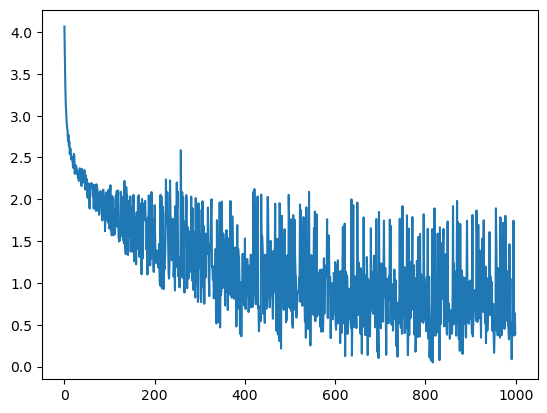

In [225]:
plt.plot(lossi)

In [230]:
for _ in range(10):
    print(model.sample())

mecq
simii
simi
sinin
siéii
diri
mene
sili
sini
sirii


In [227]:
# AdamW, 0.01, d_model = 64, n_heads = 8, d_query=16 : bon loss, mais sample très bizarre
# AdamW, 0.01, d_mode = 32, n_heads = 1, d_query = 16, loss autour de 1.8, sample très bon
# pareil en 2 heads : loss bon, sample très bizarre... (sample tout le temps des s et des i genre sini sili sirii ...)

In [82]:
from losscape.create_landscape import create_2D_losscape, create_3D_losscape

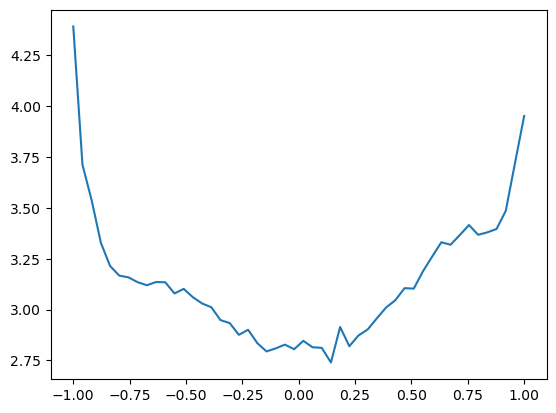

<Figure size 640x480 with 0 Axes>

In [84]:
X, losses = create_2D_losscape(model, get_batch=get_batch)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


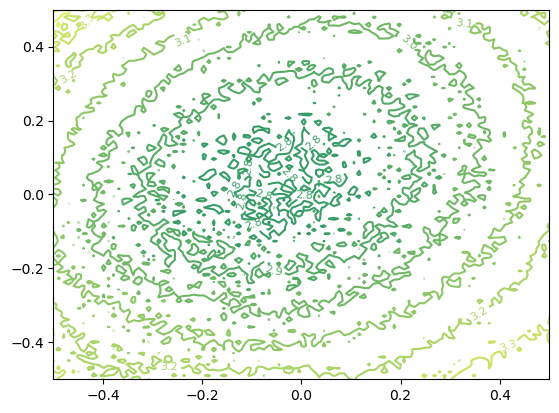

Here's your output file:losscape_log.vtp
number_points = 10000 points
matrix_size = 100 x 100
poly_size = 99 x 99
number_polys = 9801
Done with file:losscape_log.vtp
Here's your output file:losscape.vtp
number_points = 10000 points
matrix_size = 100 x 100
poly_size = 99 x 99
number_polys = 9801
Done with file:losscape.vtp


<Figure size 640x480 with 0 Axes>

In [83]:
X, Y, losses = create_3D_losscape(model, get_batch=get_batch, num_batches=10, num_points=100, output_vtp=True, x_min=-0.5, x_max=0.5, y_min=-0.5, y_max=0.5)

In [41]:
losses

array([[ 3.42139256,  3.41222954,  3.47096753, ...,  3.08790863,
         3.06346095,  3.06966829],
       [ 3.57993209,  3.45590961,  3.31783211, ...,  3.05978942,
         3.06527781,  3.09023595],
       [ 3.81902397,  3.27479172,  3.65264177, ...,  3.06037104,
         3.08424819,  3.11108458],
       ...,
       [24.29110718, 20.95235825, 14.70007896, ...,  3.81523883,
         4.27774274,  3.69545734],
       [21.9875946 , 18.02406025, 18.34983397, ...,  3.72872365,
         3.87391663,  5.47629237],
       [23.17934418, 17.3145752 , 19.06894684, ...,  3.86264038,
         4.25823545,  5.26807535]])

In [1]:
import numpy as np

In [6]:
np.finfo(np.single).max

3.4028235e+38